In [2]:
import os
import time
import warnings
import numpy as np
import keras
import tensorflow as tf
import random
import csv
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

In [3]:
def createXYImpliedProbs(data):
    XY, ImpliedProbs = np.split(data,[-2],axis=1)
    gIY, ScoreX = np.split(XY,[2],axis=1)
    Score, X = np.split(ScoreX,[2],axis=1)
    gameIDs, Y = np.split(gIY,[1],axis=1)
#     print(X[0])
    return X, Y, ImpliedProbs, gameIDs
    
    

In [4]:
def standardizeInputs(data):
    # create scaler
    scaler = StandardScaler()
    # fit scaler on data
    scaler.fit(data)
    # apply transform
    standardized = scaler.transform(data)
    return standardized

In [5]:
def stripQuotes(data):
    answer = []
    for entry in data:
#         print(entry)
        curRow = []
        for i in range(len(entry)):
#             print(entry[i])
            curEntry = entry[i].replace("\"","")
            curRow.append(curEntry)
        answer.append(curRow)
    answer = np.array(answer)
    return answer
            

In [6]:
def brier_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [7]:
def payoffs(combinedMatrix, impliedProbs):
    resultFile = "modelPayoffs.csv"
    predFile = open(resultFile, "w")
    writer = csv.writer(predFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    #combined matrix = [gameID, prediction, outcome]
    writer.writerow(["mdlTm1","mktTm1","betTm1?","payoff","profit"])
    upsets = []
    nonUpsets = []
    payoffs = []
    beatMarket = []
    for i in range(len(combinedMatrix)):
        currentRow = []
        modelTeam1Odds = combinedMatrix[i][1]
        marketTeam1Odds = impliedProbs[i][0]
        currentRow.append(modelTeam1Odds)
        currentRow.append(marketTeam1Odds)
        # if model thinks team 1 has a better chance to win than the market
        if modelTeam1Odds >= marketTeam1Odds:
            currentRow.append(1)
            # if team1 wins, add payoff to matrix
            if combinedMatrix[i][2] == 1:
                payoffs.append((1/impliedProbs[i][0]))
                currentRow.append((1/impliedProbs[i][0]))
                currentRow.append((1/impliedProbs[i][0])-1)
                beatMarket.append(1)
                writer.writerow([(1/impliedProbs[i][0])])
            else:
            #if team 1 loses, append 0
                payoffs.append(0)
                currentRow.append(0)
                currentRow.append(-1)
                beatMarket.append(0)
                writer.writerow([0])
        # if model thinks team 2 has a better chance to win than the market
        else:
            #if team 2 wins, append payoff
            currentRow.append(0)
            if combinedMatrix[i][2] == 0:
                currentRow.append((1/impliedProbs[i][1]))
                currentRow.append((1/impliedProbs[i][1])-1)
                payoffs.append((1/impliedProbs[i][1]))
                beatMarket.append(1)
                writer.writerow([(1/impliedProbs[i][0])])
            #if team 2 loses, append 0
            else:
                payoffs.append(0)
                currentRow.append(0)
                currentRow.append(-1)
                beatMarket.append(0)
                writer.writerow([0])

#         writer.writerow(currentRow)
        #if team1 is favored
        if marketTeam1Odds >= 0.5:
           #if team1 wins, nonUpset
            if combinedMatrix[i][2] == 1:
                nonUpsets.append(1)
                upsets.append(0)
            else:
                upsets.append(1)
                nonUpsets.append(0)
            
        #if team1 is underdog
        else:
            #if team1 wins, upset
            if combinedMatrix[i][2] == 1:
                upsets.append(1)
                nonUpsets.append(0)
            else:
                nonUpsets.append(1)
                upsets.append(0)
    
    lenPayoffs = len(payoffs)
    lenBM = len(beatMarket)
#     print(payoffs)
    beatMarket = np.array(beatMarket)
    calledUpsets = []
    calledNonUpsets = []
    for i in range(len(combinedMatrix)):
        #if won
        if beatMarket[i] > 0:
            #if the game that was won was an upset
            if upsets[i] > 0:
                calledUpsets.append(1)
            #if the game won was not an upset
            else:
                calledNonUpsets.append(1)
        #if lost
        else:
            if upsets[i] > 0:
                calledUpsets.append(0)
            else:
                calledNonUpsets.append(0)
    
    calledUpsets = np.array(calledUpsets)
    calledNonUpsets = np.array(calledNonUpsets)
    pctCalledUpsets = np.sum(calledUpsets)/len(calledUpsets)
    pctCalledNonUpsets = np.sum(calledNonUpsets)/len(calledNonUpsets)


    pctBeatMarket = np.sum(beatMarket)/lenBM
    payoffs = np.array(payoffs)
    totPayoffs = np.sum(payoffs)
    totProfit = totPayoffs - lenPayoffs
    print("totProfit " + str(totProfit) + " = totPayoffs " + str(totPayoffs) + " - lenPayoffs " + str(lenPayoffs))
    avgProfit = totProfit/lenPayoffs
    print("totProfit = " + str(totProfit))
    print("avgProfit = " + str(avgProfit))
    print("Win pct vs mkt = " + str(pctBeatMarket))
    return avgProfit, pctBeatMarket, pctCalledUpsets, pctCalledNonUpsets
    

In [8]:
def build_model(layers, batch_size, modelWeightFile, dropRate=0.5, loadModel = 1,learning_rate = 0.1, decay_rate = 0.005, epochs=100):
    model = Sequential()
    startWeights = keras.initializers.RandomNormal(mean=0, stddev=(1/100)**0.5, seed=-1)
    totalLayers = len(layers)
    model.add(Dense(layers[0], input_shape=(layers[0],), kernel_initializer=(startWeights)))
    model.add(BatchNormalization())
    model.add(Dropout(dropRate))
    for i in range(1,totalLayers-1):
        stddev = (1/layers[i-1])**0.5
        model.add(Dense(layers[i], activation='relu', kernel_initializer= keras.initializers.RandomNormal(mean=0, stddev=stddev, seed=-1)))
        model.add(BatchNormalization())
        model.add(Dropout(dropRate))
    model.add(Dense(layers[-1], activation='relu'))
    model.add(Dense(1, activation='sigmoid' )) # linear for spread, sigmoid for win/loss
    if loadModel > 0:
        model.load_weights(modelWeightFile)
    start = time.time()
	# model.compile(loss="mse", optimizer="adam") #for spread
    decay_steps = 1.0
    decay_rate = decay_rate
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(learning_rate, decay_steps, decay_rate)
    model.compile(loss="binary_crossentropy", optimizer="adam") #for win/loss
    print("> Compilation Time : ", time.time() - start)
    return model

In [9]:
def hyperModelsCovar(startIndex, endIndex):
    allPreds = []
    outFileName = "practicePredsCorrMatrix.csv"
    outFile = open(outFileName, "w")
    writer = csv.writer(outFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    
    for i in range(startIndex,endIndex+1):
        inFileCur = "practicePreds"+str(i)+".csv"
        predFile = open(inFileCur, "r")
        reader = csv.reader(predFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
        

        
        currentPreds = []
        for row in reader:
            if len(row) < 4:
                currentPreds.append(float(row[1]))
        currentPreds = np.array(currentPreds)
#         print(str(i) + " shape = " )
#         print(currentPreds.shape)
#         print(str(i) + " - " + str(currentPreds.shape))
        allPreds.append(currentPreds)
    allPreds = np.array(allPreds)
#     print(allPreds.shape)
    corrMatrix = np.corrcoef(allPreds)
    
    for row in corrMatrix:
        writer.writerow(row)
#     print(corrMatrix)

In [10]:
def hyperModelsResults(startIndex, endIndex):
    allStats = []
    outFileName = "practicePredsDescStats.csv"
    outFile = open(outFileName, "w")
    writer = csv.writer(outFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    
    for i in range(startIndex,endIndex+1):
        inFileCur = "practicePreds"+str(i)+".csv"
        predFile = open(inFileCur, "r")
        reader = csv.reader(predFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
        currentStats = [i]
        startStats = 0
        thisRow = 0
        for row in reader:
            if len(row)>4:
                if thisRow == 1:
#                     print(row)
                    for j in range(len(row)):
                        currentStats.append(float(row[j]))
                    thisRow = 0
                else:
                    thisRow = 1
        allStats.append(currentStats)
    allStats = np.array(allStats)
    for row in allStats:
        writer.writerow(row)

In [11]:
def makeFavoredOdds(predictions):
	answer = []
	transform = 0
	lenPreds = len(predictions)
	for i in range(0, lenPreds):
		if predictions[i] > .5:
			answer.append(-100*(predictions[i]/(1-predictions[i])))
		elif predictions[i] == .5:
			answer.append(100)
		else:
			transform = 1 - predictions[i]
			answer.append(-100*(transform/(1-transform)))
	return answer 

In [12]:
def evaluateTest(combinedMatrix):
    totalPredictions = len(combinedMatrix)
    residuals = []
    correctDirection = []
    winTot = 0
    winnings = []
    preds = []
    outcomes = []
    for i in range(totalPredictions):
        preds.append(combinedMatrix[i][1])
        outcomes.append(combinedMatrix[i][2])
        moneylineOdds = makeFavoredOdds(preds)
    print("pred \t act \t cor? \t ML odds")
    for i in range(0, totalPredictions):
        resid = combinedMatrix[i][1] - combinedMatrix[i][2]
        residuals.append(resid)
        direction = 0
        if combinedMatrix[i][1] >= 0.5:
            if combinedMatrix[i][2] == 1:
                correctDirection.append(1)
            else:
                correctDirection.append(0)
        else:
            if combinedMatrix[i][2] == 0:
                correctDirection.append(1)
            else:
                correctDirection.append(0)
        if i < 10:
            print(str("%.4f" % combinedMatrix[i][1]) + "\t" + str(combinedMatrix[i][2][0]) + "\t" + str(correctDirection[i]) + '\t'+ str("%.2f" % moneylineOdds[i]))
    residuals = np.array(residuals)
    stdResid = np.std(residuals)
    avgResid = np.average(residuals)
    correctDirection = np.array(correctDirection)
    avgDir = np.average(correctDirection)
    npWinnings = np.array(winnings)
    avgWin = np.average(winnings)
    print("average error = " + str(avgResid))
    print("stdev error = \t" + str(stdResid))
    print("percent direction correct " + str(avgDir))
    return avgResid, stdResid, avgDir
	# print("total winnings " + str(winTot))
	# print("expected profit per bet " + str(avgWin))
# 	payoffs = makeReturns(moneylineOdds, outcomes)

# 	npMoneylineOdds = np.array(moneylineOdds)
# 	npPayoffs = np.array(payoffs)

In [13]:
def brier_eval(combinedMatrix):
    totalPredictions = len(combinedMatrix)
    residuals = []
    correctDirection = []
    winTot = 0
    winnings = []
    preds = []
    outcomes = []
    for i in range(totalPredictions):
        preds.append(combinedMatrix[i][1])
        outcomes.append(combinedMatrix[i][2][0])
        moneylineOdds = makeFavoredOdds(preds)
    totalBrierScore = 0
    for i in range(0, totalPredictions):
        brierIndivid = (preds[i] - outcomes[i])**2
        totalBrierScore += brierIndivid
    avgBrier = totalBrierScore/totalPredictions
    return avgBrier


In [14]:
def randomHyperParameters():
    learning_rate = .2 + (random.random() * 0.05) #10 ** (-3 * random.random()) 
    decay_rate = 1.5 * (10 ** (-4))
    drop_rate = 0.6 + (random.random()*0.05) #(random.random() * .45) + .05
    epochs = 50
    batch_size = 256 #2 ** int(3 * random.random() + 7)
    hid1 = 500#int(75 * random.random()+500)
    hid2 = 240#int(75 * random.random()+175)
    hid3 = 60#int(25 * random.random()+50)
    hid4 = 25#int(10*random.random()+25)
    hid5 = 13#int(5*random.random()+10)
    return learning_rate, decay_rate, drop_rate, epochs, batch_size, hid1, hid2, hid3, hid4, hid5
    
    

In [15]:
def getHyperXY():
    hyperFileName = "practicePredsDescStats.csv"
    hyperData = np.loadtxt(open(hyperFileName, "r"),dtype=np.unicode_, delimiter=",")
    lenHyper = len(hyperData)
    X = []
    y = []
    for i in range(lenHyper):
        curXRow = []
        if i == 0:
            continue
        ######### E[r] as Y ##########
        yIndex = 1
        # 9 = learning rate, 10 = decay_rate, 11 = dropout, 12 = epochs, 13 = batch size, 14-18 = hid layer sizes
        XIndices = [9,11]
        for j in XIndices:
            curXRow.append(float(hyperData[i][j][1:-1]))
        X.append(curXRow)
        y.append(float(hyperData[i][yIndex][1:-1]))
    X = np.array(X)
    y = np.array(y)

    return X, y
        

In [16]:
def getModelMarketPreds(combinedMatrix, impliedProbs):
    X = []
    y = []
    for i in range(len(combinedMatrix)):
        currentRow = []
        modelTeam1Odds = float(combinedMatrix[i][1])
        marketTeam1Odds = float(impliedProbs[i][0])
        currentRow.append(modelTeam1Odds)
        currentRow.append(marketTeam1Odds)
        y.append(float(combinedMatrix[i][2][0]))
        X.append(currentRow)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [17]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# inFileTrain = "modelTrainData.csv"
# inFileDev = "modelDevData.csv"
inFileTest = "modelTestData.csv"

# trainData = np.loadtxt(open(inFileTrain, "r"),dtype=np.unicode_, delimiter=",")
# devData = np.loadtxt(open(inFileDev, "r"), dtype=np.unicode_, delimiter=",")
testData = np.loadtxt(open(inFileTest, "r"), dtype=np.unicode_,delimiter=",")

# trainDataStrip = stripQuotes(trainData)
# devDataStrip = stripQuotes(devData)
testDataStrip = stripQuotes(testData)



test_X_str, test_Y_str, test_ImpliedProbs_str, testGameIds = createXYImpliedProbs(testDataStrip)
# train_X_str, train_Y_str, train_ImpliedProbs_str, trainGameIds = createXYImpliedProbs(trainDataStrip)
# dev_X_str, dev_Y_str, dev_ImpliedProbs_str, devGameIds = createXYImpliedProbs(devDataStrip)


test_X = test_X_str.astype(np.float)
test_X = standardizeInputs(test_X)
test_Y = test_Y_str.astype(np.float)
test_ImpliedProbs = test_ImpliedProbs_str.astype(np.float)
test_X = np.concatenate((test_X,test_ImpliedProbs), axis=1)


# train_X = train_X_str.astype(np.float)
# train_X = standardizeInputs(train_X)
# train_Y = train_Y_str.astype(np.float)
# train_ImpliedProbs = train_ImpliedProbs_str.astype(np.float)
# train_X = np.concatenate((train_X,train_ImpliedProbs), axis=1)


# dev_X = dev_X_str.astype(np.float)
# dev_X = standardizeInputs(dev_X)
# dev_Y = dev_Y_str.astype(np.float)
# dev_ImpliedProbs = dev_ImpliedProbs_str.astype(np.float)
# dev_X = np.concatenate((dev_X,dev_ImpliedProbs), axis=1)

print(test_Y.shape)

(85, 1)


In [27]:
for h in range(25,50):
    learning_rate, decay_rate, drop_rate, epochs, batch_size, hid1, hid2, hid3, hid4, hid5 = randomHyperParameters()
    batch_size = 256
    modelWeightFile1 = "modelWeights" + str(h) + ".h5"
#     modelWeightFile1 = "modelWeightsCurrentMoreEpochs.h5"
    currentModelWeightFile = "modelWeightsCurrentMoreEpochs.h5"
    epochs = 50
    model = build_model([1408, hid1, hid2, hid3, hid4, hid5, 1], batch_size, modelWeightFile1, dropRate= drop_rate, loadModel=0, learning_rate = learning_rate, decay_rate = decay_rate,epochs= epochs)
#     model.summary()
#     model = build_model([1408, 500, 240, 60, 25, 13, 1], batch_size, currentModelWeightFile, dropRate= .65, loadModel=1, learning_rate = 0.23, decay_rate = decay_rate,epochs= epochs)


    model.fit(train_X, train_Y, batch_size=batch_size, verbose=1, epochs=epochs, validation_data=(dev_X, dev_Y))
    predictions = model.predict(dev_X, batch_size=batch_size, verbose=0)
    predictionFile = "practicePreds"+ str(h)+".csv"
    predFile = open(predictionFile, "w")
    dot_img_file = 'model_'+str(h)+'.png'
    plot_model(model, to_file=dot_img_file, show_shapes=True)
    
    writer = csv.writer(predFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

    predictionLen = len(predictions)
    combinedMatrix = []
    marketMatrix = []
    
    for i in range(predictionLen):
        row = []
        markRow = []
        gameID = devGameIds[i]
    #     stripID = gameID.replace("\"","")
        row.append(gameID)
        markRow.append(gameID)
        row.append(predictions[i][0])
        markRow.append(dev_ImpliedProbs[i][0])
        row.append(dev_Y[i])
        markRow.append(dev_Y[i])
        writer.writerow(row)
        combinedMatrix.append(row)
        marketMatrix.append(markRow)

    modAvgErr, modStdErr, modCorDir = evaluateTest(combinedMatrix)
    mktAvgErr, mktStdErr, mktCorDir = evaluateTest(marketMatrix)
    modelBrier = brier_eval(combinedMatrix)
    marketBrier = brier_eval(marketMatrix)
    print("model Brier = " + str(modelBrier))
    print("market Brier = " + str(marketBrier))
    print("model - market = " + str(modelBrier-marketBrier))
    # print(dev_ImpliedProbs)
    avgProfit, pctBeatMarket, winPctOnUpsets, winPctOnNonUpsets = payoffs(combinedMatrix, dev_ImpliedProbs)
    writer.writerow(['avgProfit','pctBeatMarket','mdlBrier','mktBrier','mod-mktBrier','modAvgErr','modStdErr','modPctDirCor'])
    writer.writerow([avgProfit,pctBeatMarket,modelBrier,marketBrier, modelBrier-marketBrier, modAvgErr, modStdErr, modCorDir])
    writer.writerow(['learning_rate', 'decay_rate','drop_rate','epochs', 'batch_size', 'hid1','hid2','hid3','hid4','hid5'])
    writer.writerow([learning_rate, decay_rate,drop_rate, epochs, batch_size, hid1, hid2, hid3, hid4, hid5])
    model.save_weights(modelWeightFile1)
    predFile.close()
    del model

> Compilation Time :  0.027252912521362305
Epoch 1/50
149/149 [==============================] - 23s 153ms/step - loss: 0.7417 - val_loss: 0.6535
Epoch 2/50
149/149 [==============================] - 13s 87ms/step - loss: 0.6871 - val_loss: 0.6516
Epoch 3/50
149/149 [==============================] - 18s 123ms/step - loss: 0.6766 - val_loss: 0.6490
Epoch 4/50
149/149 [==============================] - 16s 104ms/step - loss: 0.6679 - val_loss: 0.6378
Epoch 5/50
149/149 [==============================] - 17s 111ms/step - loss: 0.6556 - val_loss: 0.6272
Epoch 6/50
149/149 [==============================] - 12s 83ms/step - loss: 0.6410 - val_loss: 0.6187
Epoch 7/50
149/149 [==============================] - 12s 82ms/step - loss: 0.6296 - val_loss: 0.6082
Epoch 8/50
149/149 [==============================] - 14s 95ms/step - loss: 0.6174 - val_loss: 0.5923
Epoch 9/50
149/149 [==============================] - 14s 93ms/step - loss: 0.6085 - val_loss: 0.5869
Epoch 10/50
149/149 [==============

In [31]:
hyperModelsCovar(25,49)
hyperModelsResults(25,49)
# # predictionsTest = model.predict(test_X, batch_size=batchSize, verbose=0)3

In [ ]:
# X, y = getHyperXY()
# # X = MinMaxScaler(X)
# # print(y)
# kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
# X_kpca = kpca.fit_transform(X)
# X_back = kpca.inverse_transform(X_kpca)
# pca = PCA()
# X_pca = pca.fit_transform(X)

# # Plot results

# plt.figure()
# plt.subplot(2, 2, 1, aspect='equal')
# plt.title("Original space")
# reds = y < 0.27
# blues = y >= 0.27

# plt.scatter(X[reds, 0], X[reds, 1], c="red",
#             s=20, edgecolor='k')
# plt.scatter(X[blues, 0], X[blues, 1], c="blue",
#             s=20, edgecolor='k')
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")

# X1, X2 = np.meshgrid(np.linspace(-.1, .1, 20), np.linspace(-.1, .1, 20))
# X_grid = np.array([np.ravel(X1), np.ravel(X2)]).T
# # projection on the first principal component (in the phi space)
# Z_grid = kpca.transform(X_grid)[:, 0].reshape(X1.shape)
# plt.contour(X1, X2, Z_grid, colors='grey', linewidths=1, origin='lower')

# plt.subplot(2, 2, 2, aspect='equal')
# plt.scatter(X_pca[reds, 0], X_pca[reds, 1], c="red",
#             s=20, edgecolor='k')
# plt.scatter(X_pca[blues, 0], X_pca[blues, 1], c="blue",
#             s=20, edgecolor='k')
# plt.title("Projection by PCA")
# plt.xlabel("1st principal component")
# plt.ylabel("2nd component")

# plt.subplot(2, 2, 3, aspect='equal')
# plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
#             s=20, edgecolor='k')
# plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
#             s=20, edgecolor='k')
# plt.title("Projection by KPCA")
# plt.xlabel(r"1st principal component in space induced by $\phi$")
# plt.ylabel("2nd component")

# plt.subplot(2, 2, 4, aspect='equal')
# plt.scatter(X_back[reds, 0], X_back[reds, 1], c="red",
#             s=20, edgecolor='k')
# plt.scatter(X_back[blues, 0], X_back[blues, 1], c="blue",
#             s=20, edgecolor='k')
# plt.title("Original space after inverse transform")
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$")

# plt.tight_layout()
# plt.show()

In [17]:
predictionFileTest = "testPreds.csv"
predFileTest = open(predictionFileTest, "w")
writerTest = csv.writer(predFileTest, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)

epochs = 0
modelWeightFileTest = "modelWeights26.h5"

batch_size = 512
drop_rate = 0.6
learning_rate = 0.2
decay_rate = 0.0025
model = build_model([1408, 500, 240, 60, 25, 13, 1], batch_size, modelWeightFileTest, dropRate= drop_rate, loadModel=1, learning_rate = learning_rate, decay_rate = decay_rate,epochs= epochs)
predictionsTest = model.predict(test_X, batch_size=batch_size, verbose=0)


predictionLenTest = len(predictionsTest)
combinedMatrixTest = []
marketMatrixTest = []
for i in range(predictionLenTest):
    row = []
    markRow = []
    gameID = testGameIds[i]
#     stripID = gameID.replace("\"","")
    row.append(gameID)
    markRow.append(gameID)
    row.append(predictionsTest[i][0])
    markRow.append(test_ImpliedProbs[i][0])
    row.append(test_Y[i])
    markRow.append(test_Y[i])
    writerTest.writerow(row)
    combinedMatrixTest.append(row)
    marketMatrixTest.append(markRow)
	# print(combinedMatrix
# print(marketMatrix)
evaluateTest(combinedMatrixTest)
evaluateTest(marketMatrixTest)

# model.save(modelFile)  # creates a HDF5 file 'my_model.h5'
# model.save_weights(modelWeightFile)

> Compilation Time :  0.01618194580078125
pred 	 act 	 cor? 	 ML odds
0.4967	1.0	0	-101.35
0.8122	1.0	1	-432.39
0.9918	1.0	1	-12097.18
0.4549	1.0	0	-119.82
0.1336	0.0	1	-648.71
0.5135	1.0	1	-105.54
0.5045	1.0	1	-101.83
0.4804	1.0	0	-108.17
0.8661	1.0	1	-646.77
0.2569	0.0	1	-289.26
average error = -0.07250746663878946
stdev error = 	0.4086856608204248
percent direction correct 0.7176470588235294
pred 	 act 	 cor? 	 ML odds
0.4444	1.0	0	-125.00
0.6491	1.0	1	-185.00
0.7727	1.0	1	-340.00
0.6154	1.0	1	-160.00
0.2778	0.0	1	-260.00
0.6364	1.0	1	-175.00
0.4082	1.0	0	-145.00
0.5455	1.0	1	-120.00
0.6364	1.0	1	-175.00
0.5238	0.0	0	-110.00
average error = -0.04839452636470507
stdev error = 	0.47906114036046626
percent direction correct 0.6


(-0.04839452636470507, 0.47906114036046626, 0.6)

In [18]:
modelBrierTest = brier_eval(combinedMatrixTest)
marketBrierTest = brier_eval(marketMatrixTest)
print("model Brier = " + str(modelBrierTest))
print("market Brier = " + str(marketBrierTest))
print("model - market = " + str(modelBrierTest-marketBrierTest))
expProfit, winPctVsMkt, winPctOnUpsets, winPctOnNonUpsets = payoffs(combinedMatrixTest, test_ImpliedProbs)

model Brier = 0.17228130207860246
market Brier = 0.23184160638553433
model - market = -0.05956030430693188
totProfit 44.940674331042715 = totPayoffs 129.94067433104271 - lenPayoffs 85
totProfit = 44.940674331042715
avgProfit = 0.5287138156593261
Win pct vs mkt = 0.6941176470588235


In [20]:
print(test_X_str)

[['0.5' '34.5' '5.7' ... '4.7' '10.4' '0.45']
 ['0.5' '34.9' '9.7' ... '4.6' '11.1' '0.412']
 ['0.5' '32.9' '5.4' ... '2.2' '5.1' '0.422']
 ...
 ['0.5' '34.3' '8.7' ... '2' '3' '0.642']
 ['0.5' '34.3' '7.7' ... '3.4' '7.7' '0.444']
 ['0.5' '29.7' '4.4' ... '2' '4.6' '0.43']]


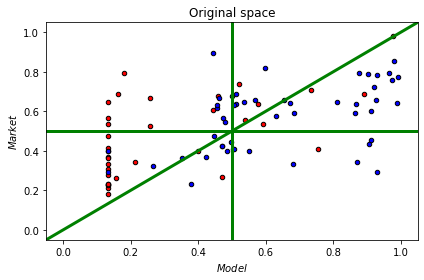

In [21]:
X, y = getModelMarketPreds(combinedMatrixTest, test_ImpliedProbs)
# print(y)
# X = MinMaxScaler(X)
# print(y)

# Plot results

plt.figure()
plt.title("Original space")
reds = y < 1
blues = y >= 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.axline((0, 0), (1, 1), linewidth=3, color='g')
plt.axvline(x=0.5,linewidth=3, color='g')
plt.axhline(y=0.5,linewidth=3, color='g')


plt.xlabel("$Model$")
plt.ylabel("$Market$")

plt.tight_layout()
plt.savefig('modVSmkt.png')
plt.show()


In [ ]:
del model